our approach is to diagnose ICD disorder using machine learning and NLP.
as the data set is very large, we only used 3 disorders and classify them
first we merge the data with notes based on admission and subjects
after that we seprated notes as features and icd code as label.
After cleaning text data we converted the text to encodings using TF-IDF and classify them
For classification purpose we used linear regression, svm and navie bayes


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
diagnosis=pd.read_csv('DIAGNOSES_ICD.csv')
diagnosis.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [2]:
len(diagnosis)

651047

In [3]:
#let filtered the data by only considering the first diagnosis (most important)

In [4]:
diagnosis=diagnosis[diagnosis.SEQ_NUM==1]
print(len(diagnosis))
diagnosis.head()

58929


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
14,1311,109,173633,1.0,40301
28,1488,112,174105,1.0,53100
33,1493,113,109976,1.0,1915
36,1496,114,178393,1.0,41401


Text(0.5, 1.0, 'Top 10 ICD codes')

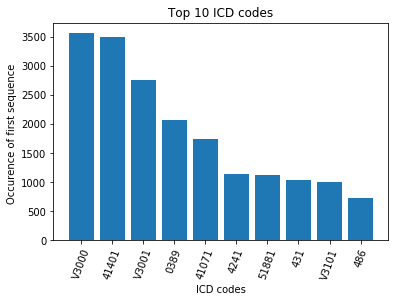

In [5]:
top10=diagnosis.ICD9_CODE.value_counts().head(10).reset_index()
top10.columns=['ICD', 'Counts']
plt.bar(top10.ICD,top10.Counts)
plt.xticks(top10.ICD,rotation=70);
plt.xlabel('ICD codes')
plt.ylabel('Occurence of first sequence ')
plt.title('Top 10 ICD codes')

In [6]:
#from here we will took  three ICD codes

In [7]:
selected_code=diagnosis[(diagnosis.ICD9_CODE=='0389') | (diagnosis.ICD9_CODE=='41401') | (diagnosis.ICD9_CODE=='51881')]
print(len(selected_code))
selected_code.head()

6694


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
36,1496,114,178393,1.0,41401
263,1723,137,151583,1.0,41401
433,662,85,112077,1.0,0389
543,772,97,127870,1.0,41401
552,781,99,187373,1.0,41401


In [8]:
notes=pd.read_csv('NOTEEVENTS.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
notes.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [10]:
#top 5 categories
notes.CATEGORY.value_counts().head()

Nursing/other    822497
Radiology        522279
Nursing          223556
ECG              209051
Physician        141624
Name: CATEGORY, dtype: int64

Text(0.5, 1.0, 'Top 10 Categories')

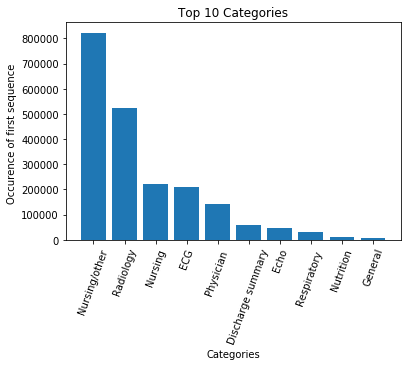

In [11]:
top10=notes.CATEGORY.value_counts().head(10).reset_index()
top10.columns=['CATEGORY', 'Counts']
plt.bar(top10.CATEGORY,top10.Counts)
plt.xticks(top10.CATEGORY,rotation=70);
plt.xlabel('Categories')
plt.ylabel('Occurence of first sequence ')
plt.title('Top 10 Categories')

In [12]:
#Merge the data
merge=selected_code.merge(notes, on=['SUBJECT_ID','HADM_ID'],how='inner',suffixes=['_Procedure','_Diagnosis'])
merge.head()

,ROW_ID_Procedure,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ROW_ID_Diagnosis,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,1496,114,178393,1.0,41401,10754,2146-09-03,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2146-8-29**] Dischar...
1,1496,114,178393,1.0,41401,150758,2146-08-29,NaN,NaN,ECG,Report,NaN,NaN,"Normal sinus rhythm, rate 96\nRight bundle bra..."
2,1496,114,178393,1.0,41401,150756,2146-09-01,NaN,NaN,ECG,Report,NaN,NaN,"Normal sinus rhythm, rate 80\nRight bundle bra..."
3,1496,114,178393,1.0,41401,150757,2146-09-01,NaN,NaN,ECG,Report,NaN,NaN,"Normal sinus rhythm, rate 85\nRight bundle bra..."
4,1496,114,178393,1.0,41401,743469,2146-08-31,2146-08-31 20:19:00,NaN,Radiology,CHEST (PA & LAT),NaN,NaN,[**2146-8-31**] 8:19 PM\n CHEST (PA & LAT) ...


In [13]:
#choose text as feature and ICD code as label
features=merge.TEXT
label=merge.ICD9_CODE

In [14]:
#clean the data
features=features.str.replace('[^\w\s]','')#remove punctuation
features=features.str.replace('[\d+]','')#remove digits
features = features.replace('\n','', regex=True)#remove next line
features = features.replace('_','', regex=True)#remove underscore
features = features.replace('\s+', ' ', regex=True)#remove extra spaces

In [15]:
#split the data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features.values,label.values,test_size=0.2)

In [16]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_train_enc=encoder.fit_transform(y_train)
y_test_enc=encoder.transform(y_test)

In [17]:
#create tf idf vectorizer of text data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english',ngram_range=(1,4),max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
X_train_vec.shape, X_test_vec.shape

((158584, 5000), (39647, 5000))

In [18]:
# Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train_enc)
y_pred=clf.predict(X_test_vec)

In [20]:
from sklearn.metrics import confusion_matrix, classification_report,plot_confusion_matrix
print(classification_report(y_test_enc,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75     15282
           1       0.86      0.89      0.87     12894
           2       0.69      0.64      0.67     11471

    accuracy                           0.77     39647
   macro avg       0.76      0.76      0.76     39647
weighted avg       0.76      0.77      0.76     39647



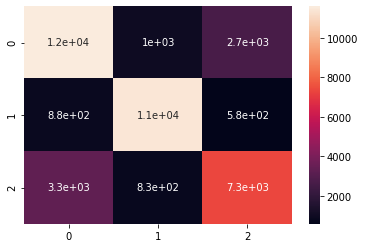

In [21]:
import seaborn as sns
cm=confusion_matrix(y_test_enc,y_pred)
sns.heatmap(cm,annot=True)

In [22]:
#naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf=GaussianNB()
clf.fit(X_train_vec.A, y_train_enc)
y_pred=clf.predict(X_test_vec.A)
print(classification_report(y_test_enc,y_pred))

In [ ]:
from sklearn.svm import LinearSVC
clf=LinearSVC()
clf.fit(X_train_vec, y_train_enc)
y_pred=clf.predict(X_test_vec)
print(classification_report(y_test_enc,y_pred))